In [83]:

import struct
import gzip
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# File paths
train_images_path = "train-images-idx3-ubyte.gz"
train_labels_path = "train-labels-idx1-ubyte.gz"
test_images_path = "t10k-images-idx3-ubyte.gz"
test_labels_path = "t10k-labels-idx1-ubyte.gz"

# Function to load IDX files
def load_idx_images(filename):
    with gzip.open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return data

def load_idx_labels(filename):
    with gzip.open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# Load data
train_images = load_idx_images(train_images_path)
train_labels = load_idx_labels(train_labels_path)
test_images = load_idx_images(test_images_path)
test_labels = load_idx_labels(test_labels_path)

# Display dataset shape
(train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape)

(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

In [43]:
# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize images (scale pixel values from [0, 255] to [0, 1])
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Flatten images (28x28 → 784 features per sample)
train_images = train_images.reshape((train_images.shape[0], 28 * 28))
test_images = test_images.reshape((test_images.shape[0], 28 * 28))

# Convert labels to one-hot encoding (for multi-class classification)
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

# Print dataset shape
print(f"Train Images Shape: {train_images.shape}, Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}, Test Labels Shape: {test_labels.shape}")


Train Images Shape: (60000, 784), Train Labels Shape: (60000, 10)
Test Images Shape: (10000, 784), Test Labels Shape: (10000, 10)


In [45]:
# Define an improved neural network model
def create_improved_model(hidden_layers=3, hidden_nodes=256, dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(784,)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    for _ in range(hidden_layers - 1):  # Add additional hidden layers
        model.add(Dense(hidden_nodes))
        model.add(LeakyReLU(alpha=0.01))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(10, activation='softmax'))  # Output layer
    return model


In [9]:
# Define an improved neural network model
def create_improved_model(hidden_layers=3, hidden_nodes=256, dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(784,)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    for _ in range(hidden_layers - 1):  # Add additional hidden layers
        model.add(Dense(hidden_nodes))
        model.add(LeakyReLU(alpha=0.01))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(10, activation='softmax'))  # Output layer
    return model


In [47]:
# Function to compile and train the model
def compile_and_train(model, learning_rate, epochs, batch_size, train_images, train_labels, val_images, val_labels):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Callbacks for learning rate reduction and early stopping
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(train_images, train_labels, 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(val_images, val_labels),
                        callbacks=[lr_scheduler, early_stopping],
                        verbose=1)
    
    return history


In [49]:
# Hyperparameters to experiment with
hidden_layers_options = [2, 3]
hidden_nodes_options = [256, 512]
dropout_rate_options = [0.3, 0.5]
learning_rate_options = [0.001, 0.0005]
batch_size = 128
epochs = 20

# Prepare a validation set
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Store results
results = []

# Iterate over hyperparameters
for hidden_layers in hidden_layers_options:
    for hidden_nodes in hidden_nodes_options:
        for dropout_rate in dropout_rate_options:
            for learning_rate in learning_rate_options:
                # Create and train model
                model = create_improved_model(hidden_layers=hidden_layers, hidden_nodes=hidden_nodes, dropout_rate=dropout_rate)
                history = compile_and_train(model, learning_rate, epochs, batch_size, train_images, train_labels, val_images, val_labels)
                
                # Evaluate the model
                val_loss, val_accuracy = model.evaluate(val_images, val_labels, verbose=0)
                
                results.append({
                    'hidden_layers': hidden_layers,
                    'hidden_nodes': hidden_nodes,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate,
                    'val_accuracy': val_accuracy,
                    'history': history.history
                })
                
                print(f"Trained: Layers={hidden_layers}, Nodes={hidden_nodes}, Dropout={dropout_rate}, LR={learning_rate}, Val_Acc={val_accuracy:.4f}")


C:\Users\Sagor Ahmed\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Sagor Ahmed\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8245 - loss: 0.5822 - val_accuracy: 0.9580 - val_loss: 0.1411 - learning_rate: 0.0010
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9472 - loss: 0.1708 - val_accuracy: 0.9673 - val_loss: 0.1064 - learning_rate: 0.0010
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9602 - loss: 0.1266 - val_accuracy: 0.9732 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9682 - loss: 0.1027 - val_accuracy: 0.9736 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9709 - loss: 0.0882 - val_accuracy: 0.9758 - val_loss: 0.0805 - learning_rate: 0.0010
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9752 - loss: 0.0778 - val_accuracy: 0.9765 - val_loss: 0.0797 - learning_rate: 0.0010
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9769 - loss: 0.

KeyboardInterrupt: 

In [51]:
# Find the best model based on validation accuracy
best_result = max(results, key=lambda x: x['val_accuracy'])
print("\nBest Model Configuration:")
print(f"Hidden Layers: {best_result['hidden_layers']}")
print(f"Hidden Nodes: {best_result['hidden_nodes']}")
print(f"Dropout Rate: {best_result['dropout_rate']}")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Validation Accuracy: {best_result['val_accuracy']:.4f}")



Best Model Configuration:
Hidden Layers: 2
Hidden Nodes: 256
Dropout Rate: 0.3
Learning Rate: 0.001
Validation Accuracy: 0.9842


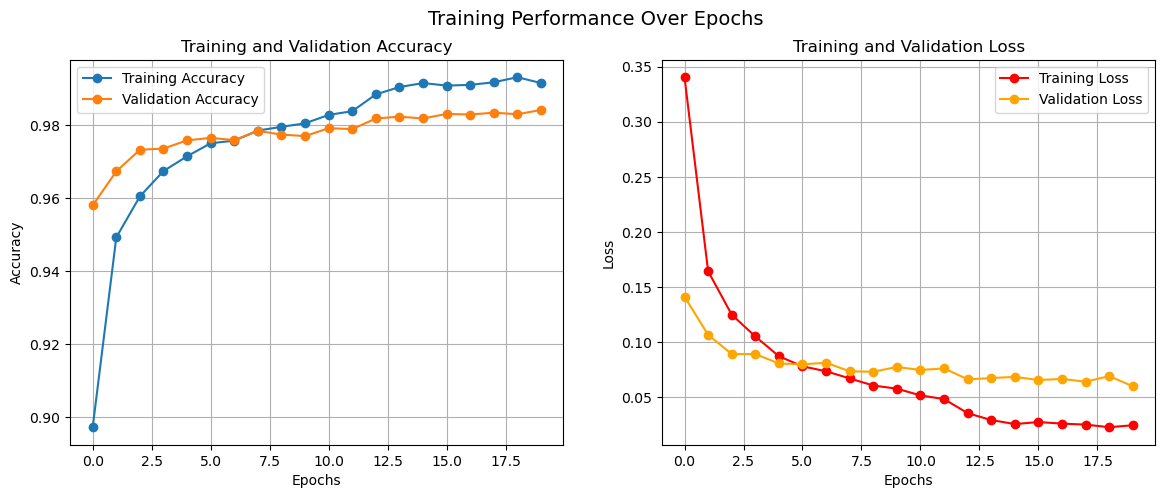

In [53]:
# Function to plot training accuracy and loss
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Accuracy
    axes[0].plot(history['accuracy'], label='Training Accuracy', marker='o')
    axes[0].plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Loss
    axes[1].plot(history['loss'], label='Training Loss', marker='o', color='red')
    axes[1].plot(history['val_loss'], label='Validation Loss', marker='o', color='orange')
    axes[1].set_title('Training and Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle("Training Performance Over Epochs", fontsize=14)
    plt.show()

# Call the function to plot training history
plot_training_history(best_result['history'])


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


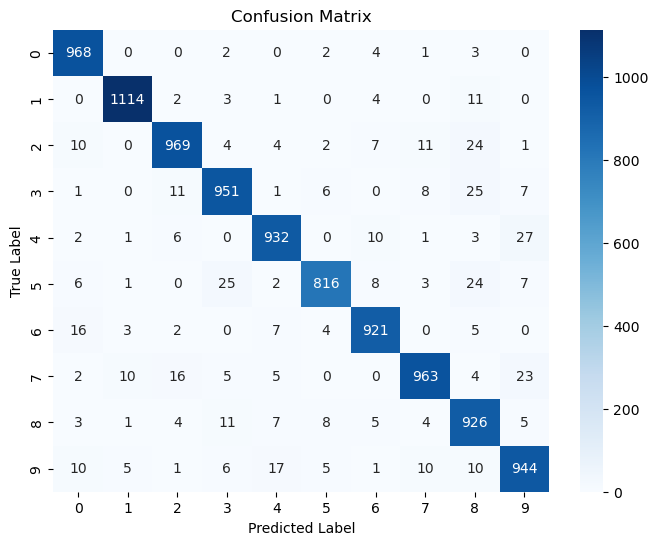

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.94      0.95      1032
           3       0.94      0.94      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.97      0.91      0.94       892
           6       0.96      0.96      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.89      0.95      0.92       974
           9       0.93      0.94      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [55]:
# Get predictions for the test set
y_pred = np.argmax(model.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)]))


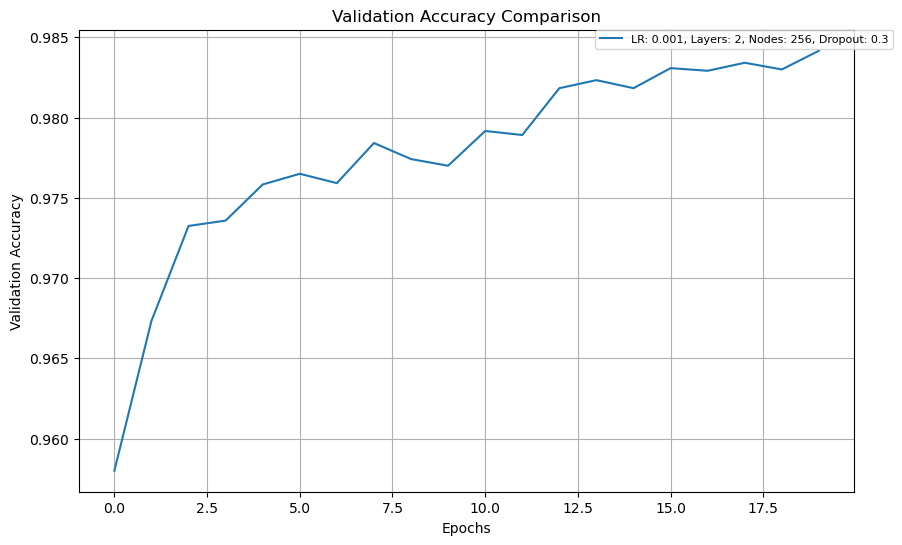

In [77]:


# Plot validation accuracy for each trained model
plt.figure(figsize=(10, 6))

for result in results:
    plt.plot(result['history']['val_accuracy'], 
             label=f"LR: {result['learning_rate']}, Layers: {result['hidden_layers']}, Nodes: {result['hidden_nodes']}, Dropout: {result['dropout_rate']}")

# Formatting
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(loc='best', fontsize=8, bbox_to_anchor=(1.05, 1), borderaxespad=0.)  # Move legend outside the plot
plt.grid(True)

# Show the plot
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


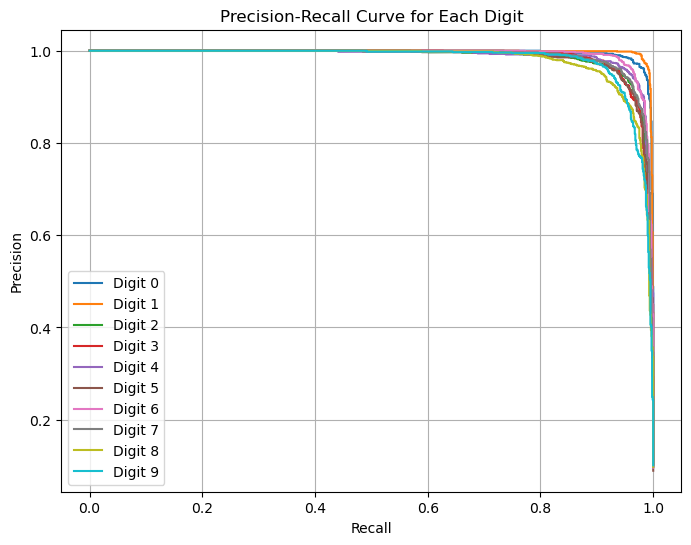

In [57]:
from sklearn.metrics import precision_recall_curve

# Get probability scores for test images
y_prob = model.predict(test_images)

# Compute precision-recall curve
precision = {}
recall = {}
plt.figure(figsize=(8, 6))

for i in range(10):  # Loop over each digit class
    precision[i], recall[i], _ = precision_recall_curve(test_labels[:, i], y_prob[:, i])
    plt.plot(recall[i], precision[i], label=f"Digit {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Digit")
plt.legend()
plt.grid()
plt.show()


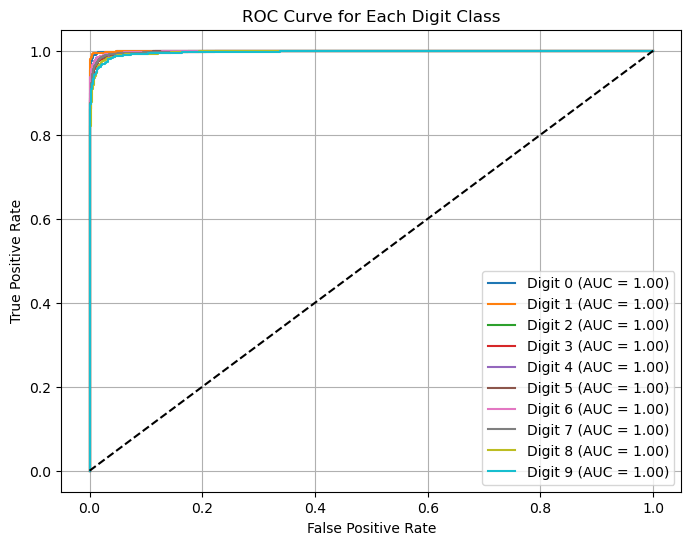

In [59]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for i in range(10):
    fpr, tpr, _ = roc_curve(test_labels[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Digit {i} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Digit Class")
plt.legend()
plt.grid()
plt.show()


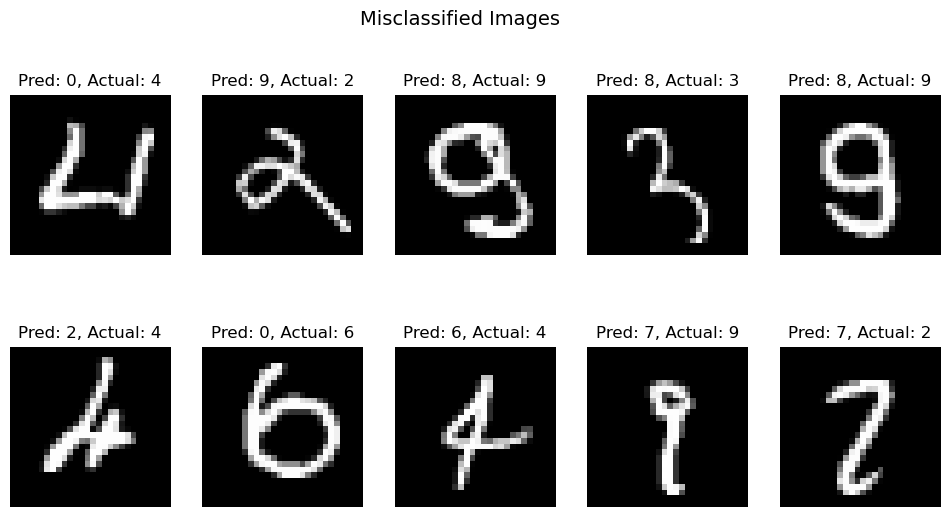

In [61]:
misclassified_idx = np.where(y_pred != y_true)[0]
num_samples = 10  # Number of misclassified samples to show

plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassified_idx[:num_samples]):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {y_pred[idx]}, Actual: {y_true[idx]}")
    plt.axis('off')

plt.suptitle("Misclassified Images", fontsize=14)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


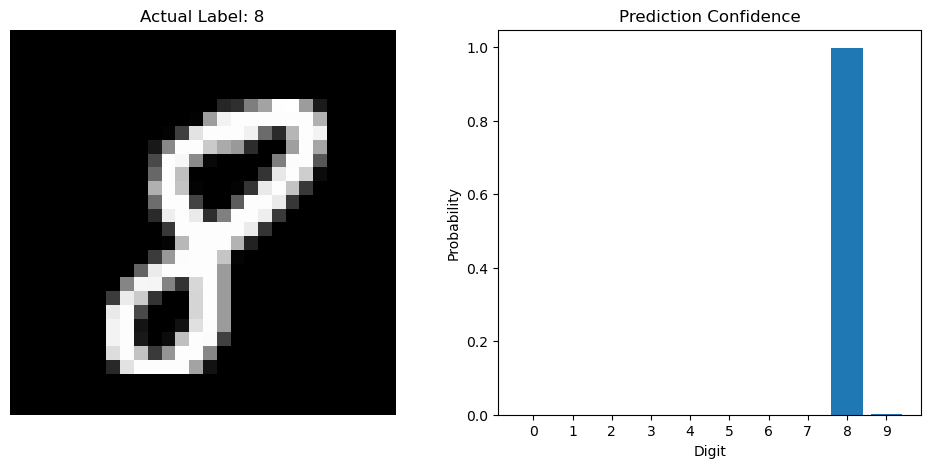

In [63]:
import random

# Pick a random test sample
random_idx = random.randint(0, len(test_images))
sample_image = test_images[random_idx].reshape(28, 28)

# Get predicted probabilities
probabilities = model.predict(test_images[random_idx:random_idx+1])[0]

# Plot image
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title(f"Actual Label: {y_true[random_idx]}")
plt.axis('off')

# Plot probabilities
plt.subplot(1, 2, 2)
plt.bar(range(10), probabilities)
plt.xticks(range(10))
plt.xlabel("Digit")
plt.ylabel("Probability")
plt.title("Prediction Confidence")

plt.show()
